Zach Barnhart
Kaggle Housing Price 

# Pre-processing

### First we will import our data into Jupyter. Since we need to evaluate our prediction model, we will not use the test data provided on Kaggle (since it does not have actual sales values for us to evaluate accuracy with), but rather we will use 5-fold cross-validation from the training data provided as an indication of the average accuracy of the different types of models we will try.

### We will want to use readr's read_csv method because it handles NA values in a way that will be easier to handle later. This package is in tidyverse, so we load library tidyverse first. (N.B. we will need plyr later, and it needs to be loaded before dplyr, so we go ahead and load it here)

In [1]:
options(warn=-1)
library(plyr)
suppressMessages(library(tidyverse))
houses <- read_csv('train.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_double(),
  MSSubClass = col_double(),
  LotFrontage = col_double(),
  LotArea = col_double(),
  OverallQual = col_double(),
  OverallCond = col_double(),
  YearBuilt = col_double(),
  YearRemodAdd = col_double(),
  MasVnrArea = col_double(),
  BsmtFinSF1 = col_double(),
  BsmtFinSF2 = col_double(),
  BsmtUnfSF = col_double(),
  TotalBsmtSF = col_double(),
  `1stFlrSF` = col_double(),
  `2ndFlrSF` = col_double(),
  LowQualFinSF = col_double(),
  GrLivArea = col_double(),
  BsmtFullBath = col_double(),
  BsmtHalfBath = col_double(),
  FullBath = col_double()
  # ... with 18 more columns
)
See spec(...) for full column specifications.


### Let us get a brief overview of the data

In [2]:
dim(houses)
head(houses)

[1] 1460   81

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


### So we have 1460 instances of houses, with 81 total features. Looking at the data, it appears there are a lot of features with a significant number missing entries (e.g. Allet, PoolQC, Fence, MiscFeature, etc). Now, most packages with convenient linear models cannot handle NA entries, so we will need to do some preprocessing here. First, let us see how widespread missing values are in the data set as a whole:

In [3]:
print(paste('Percentage of missing values in data set: ',mean(is.na(houses)) * 100))

[1] "Percentage of missing values in data set:  5.88956536445121"


### Ok, only 6%, this is not too bad. Seeing as how certain columns appear to have many missing values, we guess that most columns likely have few or no missing values, but, either way, we need to find some kind of solution - possibly eliminate columns with too many missing values, deal with all other missing values in some way. We start by finding which columns have missing values (MissValCol) and then counting the number of values in each column and listing them in decreasing order

In [4]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        1453         1406         1369         1179          690          259 
  GarageType  GarageYrBlt GarageFinish   GarageQual   GarageCond BsmtExposure 
          81           81           81           81           81           38 
BsmtFinType2     BsmtQual     BsmtCond BsmtFinType1   MasVnrType   MasVnrArea 
          38           37           37           37            8            8 
  Electrical 
           1

# Features with Quality or Condition-type scale

### Ok, this tells us a lot of information. First, we have a lot of "quality" variables - PoolQC, GarageQual, BsmtQual, etc. As the data guide for GarageQual explains:

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
### Which makes sense, NA corresponds to no garage at all. Similarly, NA for PoolQC corresponds to no pool, NA for FireplaceQual corresponds to no fireplace, etc. Now, we want to encode these different quality features with some sort of numerical scale, we will do it in the obvious scale NA <- 0, Po <- 1, Fa <- 2, ..., Ex <- 5. Now, to assign 0 to NA, we need to change it to a string first for all these types of features. Going through the data guide (simply searching for 'Gd' does the trick), we find these features are ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC.

### First, we need to replace NA with 'No'. Looking at our list of columns that have missing values, we only need to do this for BsmtQual, BsmtCond, FireplaceQu, GarageQual, GarageCond, and PoolQC:

In [5]:
houses$BsmtQual[is.na(houses$BsmtQual)] <- 'No'
houses$BsmtCond[is.na(houses$BsmtCond)] <- 'No'
houses$FireplaceQu[is.na(houses$FireplaceQu)] <- 'No'
houses$GarageQual[is.na(houses$GarageQual)] <- 'No'
houses$GarageCond[is.na(houses$GarageCond)] <- 'No'
houses$PoolQC[is.na(houses$PoolQC)] <- 'No'

### Now we create a vector of equivalent numerical values for each string is order to encode them with revalue, which is a handy method for encoding available in the plyr package (which we loaded earlier). We do this for all variables with this clear numerical scale equivalent, even those that didn't have missing values. 

In [6]:
values <- c('No' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)

houses$ExterQual<-as.integer(revalue(houses$ExterQual, values))
houses$ExterCond<-as.integer(revalue(houses$ExterCond, values))
houses$BsmtQual<-as.integer(revalue(houses$BsmtQual, values))
houses$BsmtCond<-as.integer(revalue(houses$BsmtCond, values))
houses$HeatingQC<-as.integer(revalue(houses$HeatingQC, values))
houses$KitchenQual<-as.integer(revalue(houses$KitchenQual, values))
houses$FireplaceQu<-as.integer(revalue(houses$FireplaceQu, values))
houses$GarageQual<-as.integer(revalue(houses$GarageQual, values))
houses$GarageCond<-as.integer(revalue(houses$GarageCond, values))
houses$PoolQC<-as.integer(revalue(houses$PoolQC, values))

The following `from` values were not present in `x`: No, Po
The following `from` values were not present in `x`: No
The following `from` values were not present in `x`: Po
The following `from` values were not present in `x`: Ex
The following `from` values were not present in `x`: No
The following `from` values were not present in `x`: No, Po
The following `from` values were not present in `x`: Po, TA


### Great, let us see which columns with missing values remain

In [7]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

MiscFeature        Alley        Fence  LotFrontage   GarageType  GarageYrBlt 
        1406         1369         1179          259           81           81 
GarageFinish BsmtExposure BsmtFinType2 BsmtFinType1   MasVnrType   MasVnrArea 
          81           38           38           37            8            8 
  Electrical 
           1

# Turn categorical variables into factors

### Now, a lot of these remaining variables are simple categorical variables that happen to have no value in the case where the house entity does not have a garage, basemnet, fence, alley, etc. Now, unlike the case of quality/condition features, there is not a clear numerical scale for the values in this case, nor is it always clear that not having a value should be penalized. For instance, should not having a masonry veneer type be worse than having one? Should not having an alley be worse than having one? The answer is not clear. However, we shouldn't ditch these columns entirely, as they likely have some effect. For certain features, such as MiscFeature, we will simply assign 'None' to missing values, then we will use them as factor variables in our linear model later (in the linear model we will use, factor variables are used to calculate the difference between a base model using all instances and the model if we only consider values with a given factor for the categorical variable. It essentially uses one-hot encoding on the factor values to select which difference from the base model will be applied when we are predicting SalePrice later on, but this happens "under the hood" in the package we will use). 

### While 'None' is meaningful in the context of MiscFeature, it is less so for other features. For instance, Electrical. It is extremely unlikely that a house doesn't  have some sort of electrical set-up. Additionally, in this specific case, there is only one NA value, so having a 'None' factor with only 1 instance would probably cause an error down the line. In this type of situation, it seems more reasonable to use the mode. We will justify which option we decide on above each feature below.

In [8]:
# None is a valid category here
houses$MiscFeature[is.na(houses$MiscFeature)] <- 'None'
# None means no alley (feature describes specific alley type)
houses$Alley[is.na(houses$Alley)] <- 'None'
# None means no fence (feature describes specific fence type)
houses$Fence[is.na(houses$Fence)] <- 'None'
# None means no garage (feature describes types of garage)
houses$GarageType[is.na(houses$GarageType)] <- 'None'
# None means no Masonry Veneer (feature describes type of masonry veneer)
houses$MasVnrType[is.na(houses$MasVnrType)] <- 'None'

# Here, 'None' is unlikely, since a house has some kind of electricity, so we assume it has the most common type of electrical set-up
houses$Electrical[is.na(houses$Electrical)] <- names(sort(-table(houses$Electrical)))[1]

### In addition to these variables, let us take a look at the data guide to see if there are any other categorical variables that we can use as factors in our regression model, then we will handle them all at once. A short explanation as to why the variable will be considered as a factor is provided over each variable

In [9]:
# features from above
houses$MiscFeature <- as.factor(houses$MiscFeature)
houses$Alley <- as.factor(houses$Alley)
houses$Fence <- as.factor(houses$Fence)
houses$GarageType <- as.factor(houses$GarageType)
houses$MasVnrType <- as.factor(houses$MasVnrType)

# Type of house. Not easy to encode numerically
houses$MSSubClass <- as.factor(houses$MSSubClass)
# Describe the zoning of the property. No good numerical scale
houses$MSZoning <- as.factor(houses$MSZoning)
# It seems like this one could almost be quantified, but it is not clear how one could quantify 'banked' and
# 'hillside' differently, or if one should be better than the other.
houses$LandContour<-as.factor(houses$LandContour)
# Includes many different types of lot, many of which are categorically different (not clear which should be better)
houses$LotConfig <- as.factor(houses$LotConfig)
# Some neighbourhoods tend to have bigger, nicer houses, and some land has higher value based on location
houses$Neighborhood <- as.factor(houses$Neighborhood)
# proximity to certain large roads and railroad tracks, it is clear that being close to a highway or railroad
# might have a negative effect, but there is not a clear way to quantify this, so we will use factors
houses$Condition1 <- as.factor(houses$Condition1)
houses$Condition2 <- as.factor(houses$Condition2)
# This one contains types such as 'duplex' and 'townhome'. Not clear which should be better, so we use factors
houses$BldgType <- as.factor(houses$BldgType)
# It seems like 2-story houses should be better than 1-story houses, but there are other types like 'Split foyer' and 'Split leve'
# that are more difficult to quantify, so we will use factors
houses$HouseStyle <- as.factor(houses$HouseStyle)
# Various styles and materials for roofs. Not sure which should be better, so we go with factors
houses$RoofStyle<-as.factor(houses$RoofStyle)
houses$RoofMatl<-as.factor(houses$RoofMatl)
# Various exterior types
houses$Exterior1st <- as.factor(houses$Exterior1st)
houses$Exterior2nd <- as.factor(houses$Exterior2nd)
# Various foundation types
houses$Foundation <- as.factor(houses$Foundation)
# Various different types of heating - central forces air vs. radioator vs. floor furnace, etc.
houses$Heating <- as.factor(houses$Heating)
# Various different types of electrical systems / fuse boxes. Certain categories have a clear hierarchy, but not all do, so
# we will handle it as a factor
houses$Electrical <- as.factor(houses$Electrical)
# Financial circumstances of sale, no clear scale so we will use factor
houses$SaleType <- as.factor(houses$SaleType)
# Lastly, the condition of the sale - relationship between the parties (between family, foreclosure, normal, etc) - clearly categorical
houses$SaleCondition <- as.factor(houses$SaleCondition)

### Now things get a little tricky. We are tempted to interpret month sold as a numerical scale, but that would only allow decreasing throughout the year and increasing throughout the year to be accurately modeled. In reality, there may be some seasonality to the value of home sales - e.g. more in the Spring, less in the Fall/Winter, or vice versa. We could model this by numbering the months and then trying to find some kind of polynomial model, but it is how to know which to choose (cubed? quadratic? maybe even quartic? would higher degree overfit data?). In such a case, we will just interpret month sold as a factor

In [10]:
houses$MoSold <- as.factor(houses$MoSold)

# YrSold

### Additionally, I have my misgivings about YrSold that makes me hesitate interpreting it as a numerical variable for the purpose of a linear model. Let us take a look at its values

In [11]:
unique(houses$YrSold)

[1] 2008 2007 2006 2009 2010

### Ok, this is a relatively should period, so we are tempted to think that a trend in housing prices would persist in one direction or the other across the entire period and so we could possibly interpret this as a quantitative variable. That, however, would be a mistake in this case, since the period in question in right during the collapse of the U.S. housing bubble in 2006. Looking at the Wikipedia page for the bubble (https://en.wikipedia.org/wiki/United_States_housing_bubble), we see that homes in IA hadn't gained as much value as houses on the coasts during the preceding period.

<img src="1.png" width="600">

### However, the market collapse likely still affected the IA housing market in some way. Now, was the decrease in value linear? That is the important question (if it is, we can interpret YrSold numerically). Further down on the Wikipedia page, we find the following graph:

<img src="2.png" width="400">

### That is, in 2006, prices started to dip, in 2007, they fell a little, and a real drop-off occurred in 2008 before dipping a little more and levelling off in 2009 and 2010. It would be hard to model this polynomially (strangely shaped curve), so we think the best way to proceed will be to interpret YrSold as a factor. This will also allow us to account for the sharply negative trend of sale price over the course of 2008, since using factors essentially runs the regression separately for each group and can account for these differing trends for each year.

In [12]:
houses$YrSold <- as.factor(houses$YrSold)

### Alright, let's see where we are at with features with missing variables:

In [13]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

LotFrontage  GarageYrBlt GarageFinish BsmtExposure BsmtFinType2 BsmtFinType1 
         259           81           81           38           38           37 
  MasVnrArea 
           8

# GarageYrBuilt

### Ok, let us take care of these one-by-one. If there is no value for GarageYrBlt, it is not impossible that the garage was build or added after the home was built. Let us see how common this is.

In [14]:
houses[houses$YearBuilt != houses$GarageYrBlt,c('YearBuilt', 'YearRemodAdd','GarageYrBlt')]

YearBuilt,YearRemodAdd,GarageYrBlt
1915,1970,1998
1929,2001,1991
1951,2000,2005
2007,2008,2008
1927,1950,1920
1994,1995,1995
NA,NA,NA
1975,1980,1977
NA,NA,NA
1934,1950,1985


### Rather common, apparently. Let us see how common.

In [15]:
dim(houses[houses$YearBuilt != houses$GarageYrBlt,])/dim(houses)

[1] 0.2541096 1.0000000

### That is not too bad. In 25.41% of cases, the garage was built a different year than the house, but most of the time, the garage was built the same year as the house. Now, houses built before cars were common often have a garage built later than the house. Cars became more common in the United States around 1930, so let us see what percentage of houses built before this date has garages built significantly later (> 20 years)

In [16]:
dim(houses[(houses$YearBuilt < 1930) & (houses$GarageYrBlt > 1950),])/dim(houses[houses$YearBuilt < 1930,])

[1] 0.5081081 1.0000000

### About 50%, a not very helpful result. Is this enough to split older homes with missing GarageYrBuilt dates up into their own category and assign them GarageYrBuilt dates older than their YearBuilt dates? Let us see what percentage of the instances with missing GarageYrBuilt dates come from this category:

In [17]:
dim(houses[is.na(houses$GarageYrBlt) & (houses$YearBuilt < 1930),])/dim(houses[is.na(houses$GarageYrBlt),])

[1] 0.3950617 1.0000000

### Almost 40%. This could go either way. If they were a larger percent of the instances with missing GarageYrBuilt values, we might consider them separately, but for simplicity's sake, we will just apply the pattern most common across the entire data set - that is, we will assign them to GarageYrBuilt=YearBuilt

In [18]:
houses$GarageYrBlt[is.na(houses$GarageYrBlt)] <- houses$YearBuilt[is.na(houses$GarageYrBlt)]

### Ok, now let us look at our updated list of features with NA values

In [19]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

LotFrontage GarageFinish BsmtExposure BsmtFinType2 BsmtFinType1   MasVnrArea 
         259           81           38           38           37            8

# LotFrontage

### Next, let us look at LotFrontage, which is, as the data description explains, the linear number of street connected to the property. An initial idea might be to replace NA with the average value of this feature across all instances. But this doesn't take advantage of the fact that in residential areas, developers tend to build houses with similar features, i.e. typically houses in the same neighbourhood share certain characteristics - general size, lot size and shape, etc. A house in a nieghbourhood full of mansions will likely have quite a large frontage, as will houses in the suburban-rural boundary where the property may be delineated entirely by roads. In a neighbourhood full of row houses, the frontage will likely be exactly the same for each plot. For this reason, we may get a better estimate of the LotFrontage values by assigning to each instance with missing LotFrontage the average of whatever neightbourhood it belongs to. The one thing we must look for is the possiblity that certain neighbourhoods may not have any LotFrontage values. We will check to see if any values are still NA or 0 afterwards to make sure this is not the case.

### Now, one thing we might also be concerned about is that, since we are assigning the neighbourhood average to each missing value, there are fewer values being used to calculate the average, so outliers (e.g. a single large property in an otherwise normal residential neighbourhood) might skew the average compared to the neighbourhood norm. For these reasons, we might be better suited to use the median rather than the mean. Let us compare these two for each neighbourhood to see if we can gain some insight. We will use dplyr group-by for this purpose.

In [20]:
options(warn=-1)
library(dplyr)

In [21]:
houses %>% 
group_by(Neighborhood) %>% 
summarise(avg_frontage = mean(LotFrontage, na.rm=TRUE), 
        med_frontage = median(LotFrontage, na.rm=TRUE),
        difference = abs(avg_frontage - med_frontage),
        total = n()) %>%
        arrange(desc(difference))

`summarise()` ungrouping output (override with `.groups` argument)


Neighborhood,avg_frontage,med_frontage,difference,total
Gilbert,79.87755,65.0,14.8775510,79
Somerst,64.66667,73.5,8.8333333,86
NPkVill,32.28571,24.0,8.2857143,9
Veenker,59.71429,68.0,8.2857143,11
MeadowV,27.80000,21.0,6.8000000,17
NridgHt,81.88158,88.5,6.6184211,77
BrkSide,57.50980,52.0,5.5098039,58
SawyerW,71.50000,66.5,5.0000000,59
Timber,80.13333,85.0,4.8666667,38
Blmngtn,47.14286,43.0,4.1428571,17


### It appears the skew can go both ways. Let us look at the top two results to see why this happens.

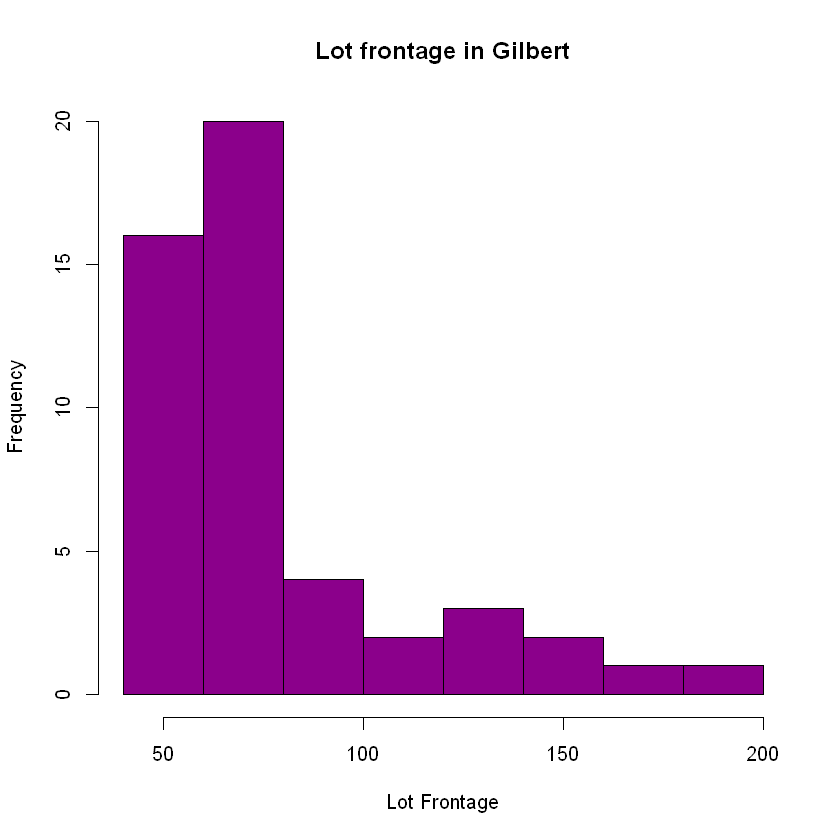

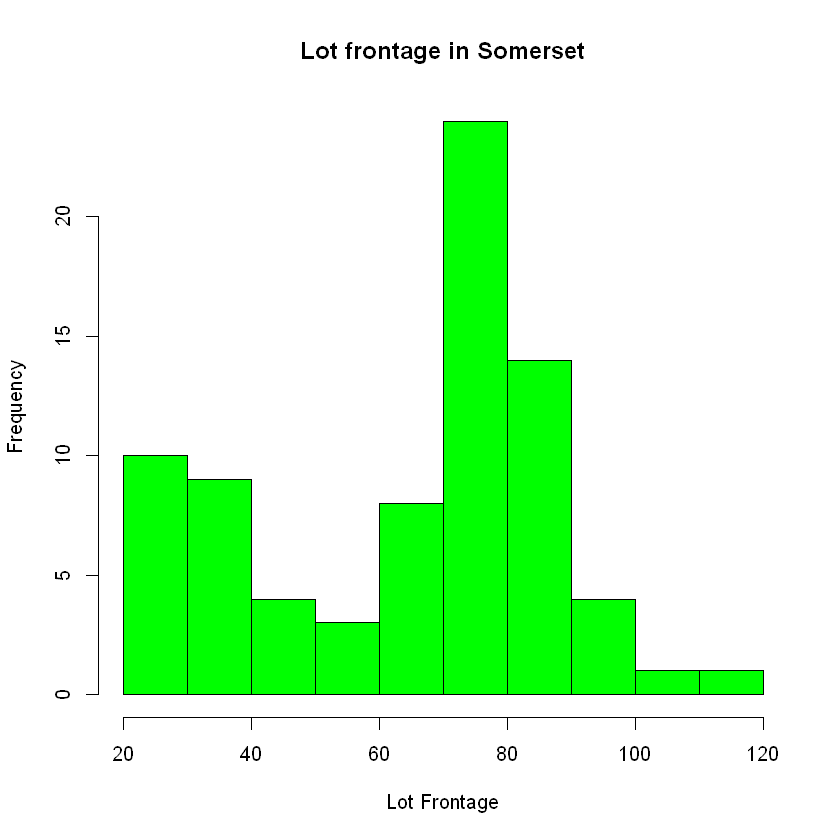

In [22]:
hist(houses[(houses$Neighborhood=='Gilbert') & (!is.na(houses$LotFrontage)), c('LotFrontage')][[1]], main="Lot frontage in Gilbert", xlab="Lot Frontage", col='darkmagenta')
hist(houses[(houses$Neighborhood=='Somerst') & (!is.na(houses$LotFrontage)), c('LotFrontage')][[1]], main="Lot frontage in Somerset", xlab="Lot Frontage", col='green')

### The case of Gilbert is more of what I was expecting to see. Mostly smaller frontages with a few large properties skewing the average. This is the type of situation where using the median is advantageous.

### In the second situation, we're seeing what appears to be a bi-model distribution, so using the median isn't necessarily the best solution, however, the fact that the median is likely to be a much better fill-in in the case of the Gilbert, the neighbourhood with the most-skewed distribution, justifies its use across the board in our opinion, since in other neighbourhoods the difference between mean and median is much lower and so using the possible worse choice for measure of central tendency doesn't have as much of an effect.

In [23]:
for (i in 1:nrow(houses)){
        if(is.na(houses$LotFrontage[i])){
               houses$LotFrontage[i] <- as.integer(median(houses$LotFrontage[houses$Neighborhood==houses$Neighborhood[i]], na.rm=TRUE)) 
        }
}

### Let us see if that worked to eliminate all NA values in LotFrontage (it should have, since in the table above we see that every neighbourhood has at least one value for LotFrontage to work with), and also see which features still have NA values

In [24]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

GarageFinish BsmtExposure BsmtFinType2 BsmtFinType1   MasVnrArea 
          81           38           38           37            8

# Various Finishes and Exposures

### Next we have a series of features of the "finishes" and "exposures" type, when offer a clear quality scale that easily translates to a numerical scale. For instance, for BsmtFinType1, we have

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

### For these features, NA will be labelled a 0, and then we will label the rest of values with 1, 2, 3, etc. up to whatever the best value is (for the best quality). First, we handle BsmtFinType1 and BsmtFinType2:

In [25]:
houses$BsmtFinType1[is.na(houses$BsmtFinType1)] <- 'No'
houses$BsmtFinType2[is.na(houses$BsmtFinType2)] <- 'No'

# Now we create a numerical scale...
FinType <- c('No'=0, 'Unf'=1, 'LwQ'=2, 'Rec'=3, 'BLQ'=4, 'ALQ'=5, 'GLQ'=6)
# ...and we use revalue to replace the strings with our numerical scale
houses$BsmtFinType1<-as.integer(revalue(houses$BsmtFinType1, FinType))
houses$BsmtFinType2<-as.integer(revalue(houses$BsmtFinType2, FinType))

### For BsmtExposure, similar thing. The data description says

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

### So we encode this in the obvious way:

In [26]:
houses$BsmtExposure[is.na(houses$BsmtExposure)] <- 'None'
Exposure <- c('None'=0, 'No'=1, 'Mn'=2, 'Av'=3, 'Gd'=4)
houses$BsmtExposure<-as.integer(revalue(houses$BsmtExposure, Exposure))

### GarageFinish is a similar story. The data description has

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

### So we encode as follows:

In [27]:
houses$GarageFinish[is.na(houses$GarageFinish)] <- 'No'
Finish <- c('No'=0, 'Unf'=1, 'RFn'=2, 'Fin'=3)
houses$GarageFinish<-as.integer(revalue(houses$GarageFinish, Finish))

### Let us see what features still have NA values

In [28]:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

MasVnrArea 
         8

# MasVnrArea

### Lastly, the case of Masonry Veneer Area. Recall that before we handled MasVnrType missing values, there were 8 of them in that feature column. It's safe to assume the same 8 instances have missing values for Masonry Veneer Area, and, since they apparently don't have a masonry veneer of any sort, it seems fitting to set these missing values to 0

In [29]:
houses$MasVnrArea[is.na(houses$MasVnrArea)] <-0

In [30]:
### Let us make sure we are done with missing values:
MissValCol <- which(colSums(is.na(houses)) > 0)
sort(colSums(sapply(houses[MissValCol], is.na)), decreasing = TRUE)

ERROR: Error in colSums(sapply(houses[MissValCol], is.na)): 'x' must be an array of at least two dimensions


### Great! Are we done? Not yet. There are a few more features we can encode on a numerical scale. We discuss each individually below

# LotShape
### From the data description:

LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
### There is definitely a increasing scale of irregularity we could encode here, but for it to be useful, it would need to correlate with SalePrice. Let us look

In [31]:
houses %>% 
group_by(LotShape) %>% 
summarise(avg_sale_price = mean(SalePrice), 
        total = n()) %>%
        arrange(desc(avg_sale_price))

`summarise()` ungrouping output (override with `.groups` argument)


LotShape,avg_sale_price,total
IR2,239833.4,41
IR3,216036.5,10
IR1,206101.7,484
Reg,164754.8,925


### We see a general tendency for more regular lots to be priced lower, but there may be confounding variables at play - perhaps larger properties tend to be more irregular compared to smaller properties, and their increased value has nothing to do with irregularity but rather size. Let us see if there is anything to this:

In [32]:
houses %>% 
group_by(LotShape) %>% 
summarise(avg_sale_price = mean(SalePrice), 
          avg_lot_area = mean(LotArea),
          price_per_area = avg_sale_price / avg_lot_area,
        total = n()) %>%
        arrange(desc(price_per_area))

`summarise()` ungrouping output (override with `.groups` argument)


LotShape,avg_sale_price,avg_lot_area,price_per_area,total
Reg,164754.8,8876.916,18.559917,925
IR1,206101.7,11894.545,17.327410,484
IR2,239833.4,23733.659,10.105200,41
IR3,216036.5,41338.200,5.226074,10


### Indeed, our price per unit area goes down with increasing irregularity. We see a similar tendency if we look at LandSlope:

LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

### We see that, while severe slope correlates with higher sales prices, it also correlates with much large lot areas, a confounding variable:

In [33]:
houses %>% 
group_by(LandSlope) %>% 
summarise(avg_sale_price = mean(SalePrice),
          avg_lot_area = mean(LotArea),
          price_per_area = avg_sale_price / avg_lot_area,
        total = n()) %>%
        arrange(desc(price_per_area))

`summarise()` ungrouping output (override with `.groups` argument)


LandSlope,avg_sale_price,avg_lot_area,price_per_area,total
Gtl,179956.8,9780.305,18.399916,1382
Mod,196734.1,14799.415,13.293372,65
Sev,204379.2,67401.923,3.032246,13


### So, it appears increasing severity of slope descreasing sale price. For both features, the decreases in price when you move from category to category are roughly linear,  so we feel good about encoding them with a simple integer sequence to put in the linear model - this is address the tendency we are observing in some way in the model.

In [34]:
houses$LandSlope<-as.integer(revalue(houses$LandSlope, c('Sev'=0, 'Mod'=1, 'Gtl'=2)))
houses$LotShape<-as.integer(revalue(houses$LotShape, c('IR3'=0, 'IR2'=1, 'IR1'=2, 'Reg'=3)))

# Other Features

### We have a yes/no feature for CentralAir, and a binary feature for Street (gravel vs. paved), which we will encode in the obvious way

In [35]:
houses$CentralAir<-as.integer(revalue(houses$CentralAir, c('N'=0, 'Y'=1)))
houses$Street<-as.integer(revalue(houses$Street, c('Grvl'=0, 'Pave'=1)))

### We have a PavedDrive feature, with values 'None', 'Partial', or 'Yes', which correspond to 3 ordered numerical values

In [36]:
houses$PavedDrive<-as.integer(revalue(houses$PavedDrive, c('N'=0, 'P'=1, 'Y'=2)))

### Now, with Utilities, let us take a look at the data description:

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

### There is a clear order of desirability here. All public utilities is best. All minus sewer access is next best. Electricity and gas is third best, and electricity only is worst. Let us encode this:

In [37]:
houses$Utilities <- as.integer(revalue(houses$Utilities, c('ELO'=1, 'NoSeWa'=2, 'NoSewr'=3, 'AllPub'=4)))

The following `from` values were not present in `x`: ELO, NoSewr


### Lastly, the meaning of categorical variable Functional is not clear from name alone. Let us take a look:

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

### This corresponds to a clear numerical scale of desirability. Typical functionality is best, and Salvage Only is the worst, with the other ratings in between in increasing levels of damage (and thus decreasing levels of desirability)

In [38]:
houses$Functional <- as.integer(revalue(houses$Functional, c('Sal'=0, 'Sev'=1, 'Maj2'=2, 'Maj1'=3, 'Mod'=4, 'Min2'=5, 'Min1'=6, 'Typ'=7)))

The following `from` values were not present in `x`: Sal


# First Model

### Now that we have pre-processed the data enough to train a model on it, we will try a linear regression model on our data. However, as noted above, we cannot 

In [39]:
suppressMessages(library(h2o))
options(warn=-1)

In [40]:
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\Admin\AppData\Local\Temp\RtmpgPCiig/h2o_Admin_started_from_r.out
    C:\Users\Admin\AppData\Local\Temp\RtmpgPCiig/h2o_Admin_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 818 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    1 year and 3 days !!! 
    H2O cluster name:           H2O_started_from_R_Admin_mds485 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   14.21 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  16 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:     

In [41]:
# Must turn data into H20Frame first
houses_h2o <- as.h2o(houses)

# Separate data into response (SalePrice) and predictors (all other features)
response <- "SalePrice"
predictors <- setdiff(names(houses_h2o), response)

  |======================================================================| 100%


In [42]:
houses_glm <- h2o.glm(family = "gaussian",
                        x = predictors,
                        y = response,
                        training_frame = houses_h2o,
                        nfolds = 5)

  |======================================================================| 100%


In [43]:
houses_glm

Model Details:

H2ORegressionModel: glm
Model ID:  GLM_model_R_1596161807875_1 
GLM Model: summary
    family     link                               regularization
1 gaussian identity Elastic Net (alpha = 0.5, lambda = 12559.0 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        257                          62                    2
     training_frame
1 houses_sid_a4fd_1

Coefficients: glm coefficients
                 names  coefficients standardized_coefficients
1            Intercept 179228.451688             180920.086914
2 Neighborhood.Blmngtn      0.000000                  0.000000
3 Neighborhood.Blueste      0.000000                  0.000000
4  Neighborhood.BrDale      0.000000                  0.000000
5 Neighborhood.BrkSide      0.000000                  0.000000

---
            names coefficients standardized_coefficients
253 EnclosedPorch    -0.010183                 -0.622396
254     3SsnPorch     0.000000                

### Wow, a average RMSLE of 0.4071075 is not very good, and puts us far down on Kaggle leaderboard. Let us see if we can improve this model.

# Remedy 1: Find and remove outliers, Remove Highly Correlated Features, Create New Features, Rinse and Repeat

### Due to the mean square error used, linear models are very sensitive to outliers. One outlier can make an otherwise good idea for a model become inaccurate for data points in the "main bunch". Let us see if we can find any outliers, and eliminate them if we find any. First, let us look at the distribution of our response variable and see if there are any trends or outliers there. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  129975  163000  180921  214000  755000 

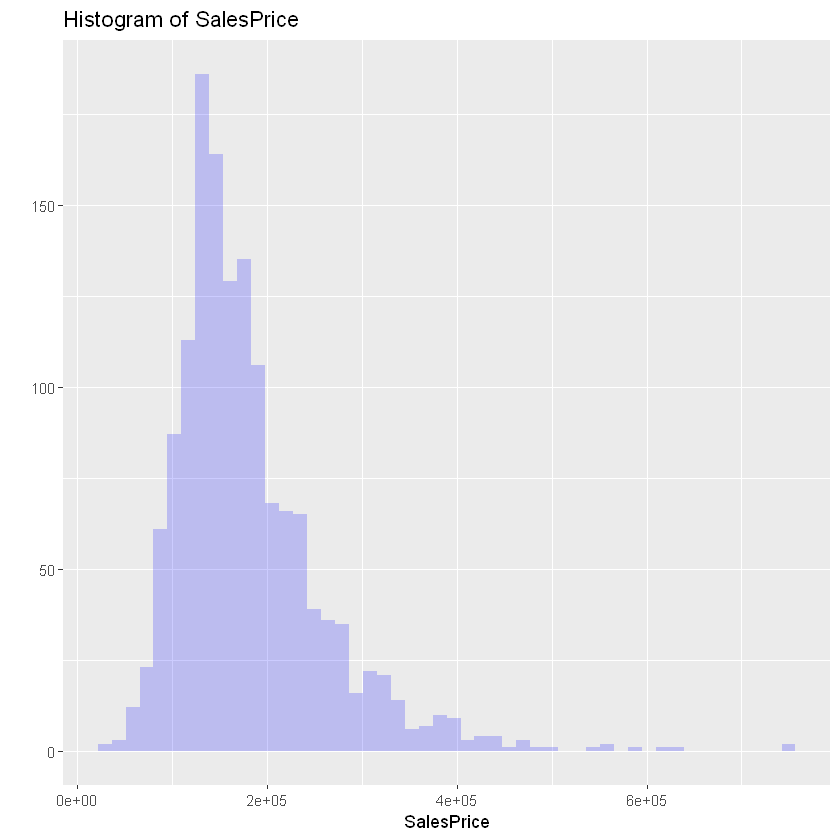

In [44]:
qplot(houses$SalePrice, geom='histogram', bins=50, alpha=I(0.2), fill=I('blue'), main='Histogram of SalesPrice', xlab='SalesPrice')
summary(houses$SalePrice)

### The response variable (SalesPrice) is rather strongly right-skewed, with a few extremely large values that may be affecting our linear model since these points are far away from the others and may have a disproportionate effect on MSE. By that I mean that if we imagine a regression line the fits the rest of the data well, it is often likely that points far away from the others won't fit the extrapolated trend line very well, so when we include them in the regression, the line may be disproportionately influenced by the need to have a small MSE for a handful of these outliers. 

### What to do? We could remove these points, but another possibility might be to take log of the SalesPrice and see if that creates a more symmetric distribution. Let us see what that looks like:

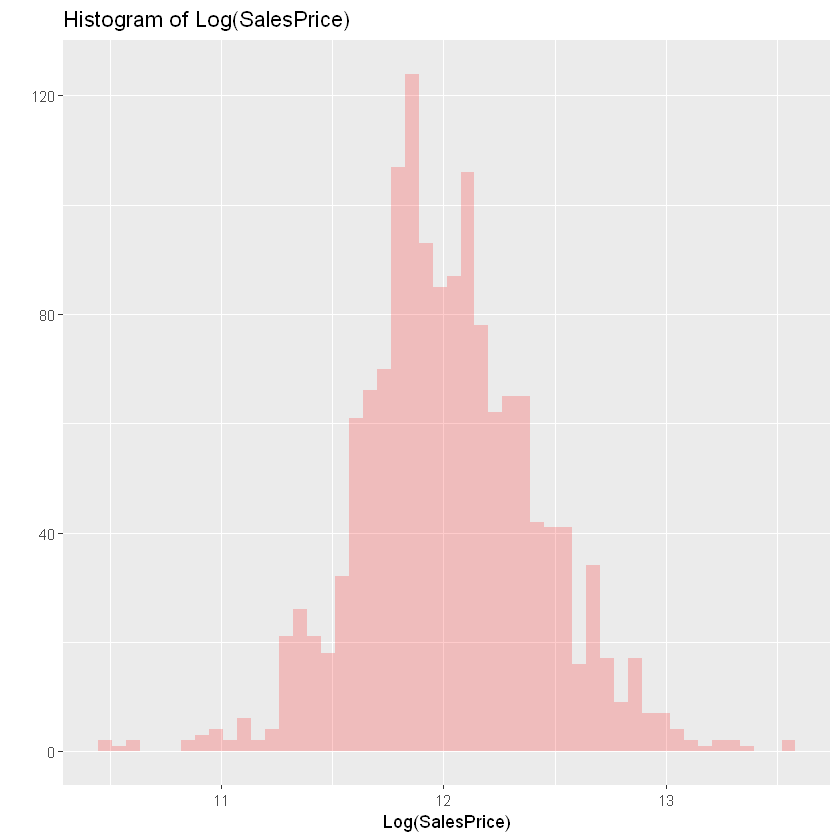

In [45]:
lSalePrice <- log(houses$SalePrice)
qplot(lSalePrice, geom='histogram', bins=50, alpha=I(0.2), fill=I('red'), main='Histogram of Log(SalesPrice)', xlab='Log(SalesPrice)')

### Not bad. We may come back to this technique later. Let us try to find outliers by looking at other features and see if these points happen to be removed when we remove these outliers.

### One assumption we are making by using this linear model directly on the data is that the response variable SalesPrice varies linearly with all of our features. Obviously, it is extremely unlikely that this is the case. Here in the outliers section, something we might look at is which features have the highest correlation with the response feature SalePrice, and then we can look at the values for this feature vs. SalePrice. If we notice that there are a few outliers we can remove to improve the correlation, we may do so to improve our model. However, if it is clear that the trend of the data is not linear, we may have to adjust certain features (or add an additional transformed feature column) that will allow us to use a linear model on these features. One think to consider is that if the data is almost linear except for the exception of a couple of outliers, we might consider removing the outliers to improve our linear model. A final think to consider is that eventually we will need to look at which features are highly correlated, and consider removing those that are, since highly correlated features can introduce noise in a linear model. 

### Here will be our strategy: we will look at which features are most highly correlated with SalePrice, as these will be the most essential to improve upon (via removing an outlier or two or making other minor adjustments) in order to improve our model. In order to do this, let us find the variables most highly correlated with SalePrice. While we are at it, we shall also take a glance at a heat map of correlations between the features that correlate most with SalePrice, to see if we might eliminate any of these features. For this we will need corrplot.

In [46]:
library(corrplot)

corrplot 0.84 loaded


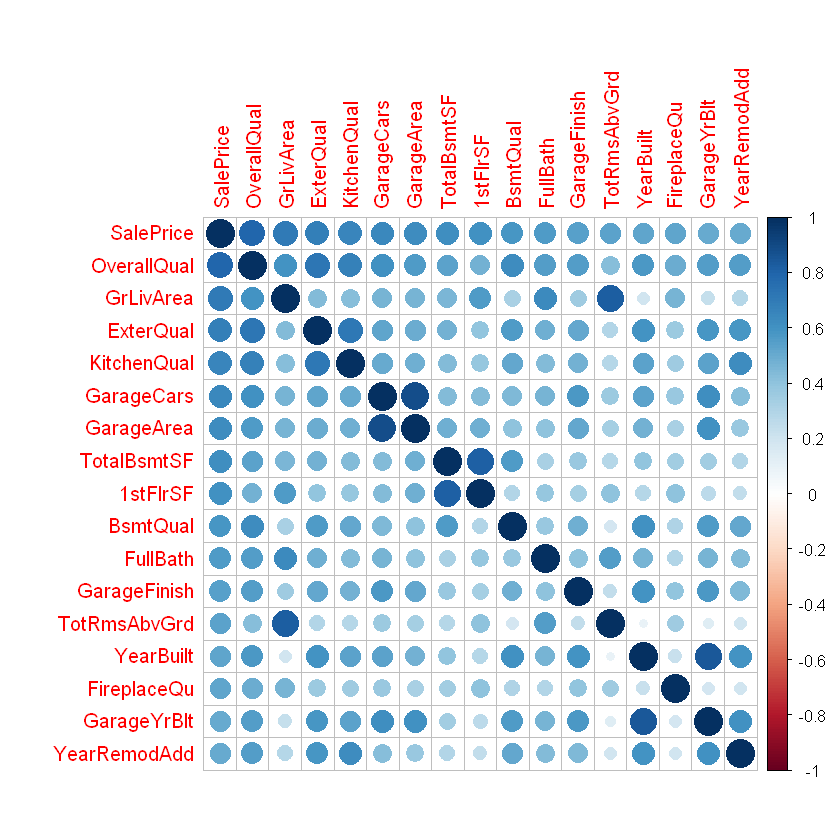

In [47]:
# First this only works for numeric variables, so let us make a df with those
numericVariables <-  unlist(lapply(houses, is.numeric))
# Now we find the correlation between the different numeric features
correlation = cor(houses[numericVariables])
# Now we will order them in order of which features have the highest correlation with SalePrice
correlation_sorted <- as.matrix(sort(correlation[,'SalePrice'], decreasing = TRUE))
# So our graphic isn't too big, let us only look at ones that have a correlation with magnitude greater than 0.5 (in either direction)
highCorrelation <- names(which(apply(correlation_sorted, 1, function(x) abs(x)>0.5)))
correlation <- correlation[highCorrelation, highCorrelation]
corrplot(correlation)

### Most of these make a lot of sense. It seems obvious that Overall Quality and External Quality should both have a strong correlation with SalePrice. We see a few more quality features pop-up - Kitchen Quality, Basement Quality, and Fireplace Quality. Additionally, we see a lot of general size features - above grade living area, garage cars/area, total basement SF, 1st floor SF, # of full bathrooms, total rooms above grade. Lastly, we see a number of features related to age of the house  - YearBuilt, GarageYrBly, and YearRemod all have a non-negligeable relationship with SalePrice.

### Now, as mentioned, what we want to do is see if there are any outliers or non-linear trends in these highly correlated features, so, is there any way we can look at this in an efficient manner? Why there is! There is a function called ggpairs in the package GGally that will help greatly in this endeavor. It provides in a single visual scatterplots of each pair of numeric variablesthat are drawn on the left part of the figure, Pearson correlation displayed on the right, and variable distribution is available on the diagonal. We can also customize the scatterplots on the (bottom) left part of the grid by writing up a new plot template and using geom_smooth to draw a line of best fit over the data. Now, to show how the data is trending overall, we will also draw via geom_smooth a line that follows the trend of the data as best as possible, but we don't want to make any assumptions about the trend, so we need something non-parametric. The loess method of geom_smooth offers this possibility, as our data set is small enough to handle it (LOESS essentially uses a spruced-up of KNN and calculates a sort of centroid trend as we move through the data set, so it is a) computationally expensive, but b) is nice to give a trend line if we don't want to make any assumptions about the data distribution). 

### So the individual plots are readable, we shall divide the features highly correlated with SalePrice into two halves and plot them separately

In [48]:
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth

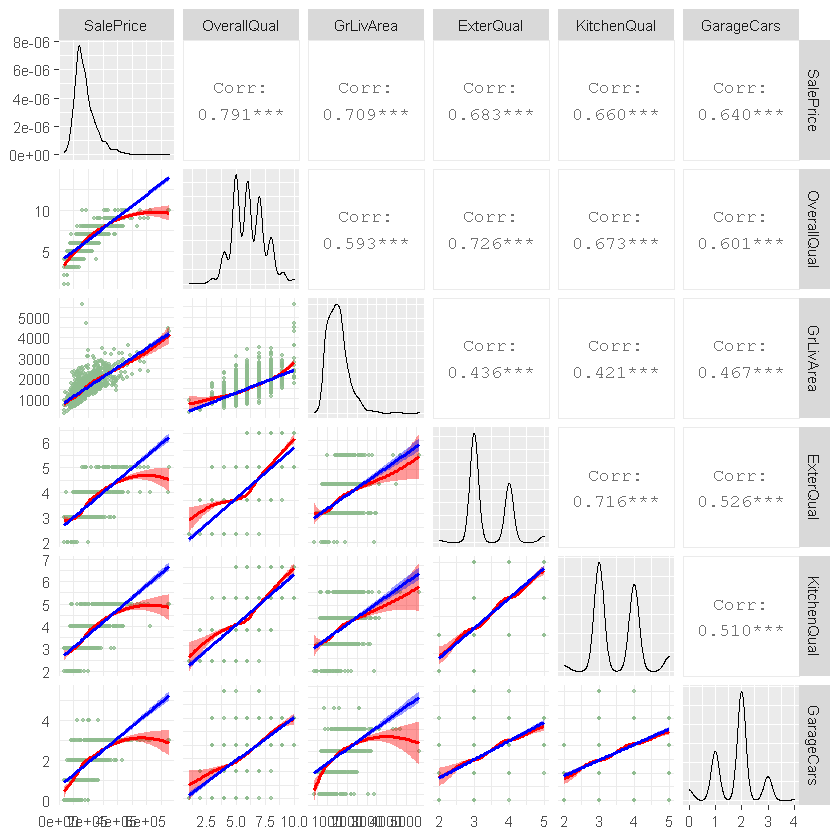

In [49]:
# So first we are going to design how we want the bottom-left plots to look
options(warn=-1)
lm.plt <- function(data, mapping, ...){
   plt <- ggplot(data = data, mapping = mapping) + 
    geom_point(shape = 20, alpha = 0.7, color = 'darkseagreen') + # Scattplot of data values for given feature vs. SalePrice
    geom_smooth(method=loess, fill="red", color="red") + # LOESS trend curve
    geom_smooth(method=lm, fill="blue", color="blue") + # line of best fit
    theme_minimal() # this prevents it from displaying information about every feature and smoothing process
  return(plt)
}

ggpairs(houses, highCorrelation[1:6], lower = list(continuous = lm.plt))

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth

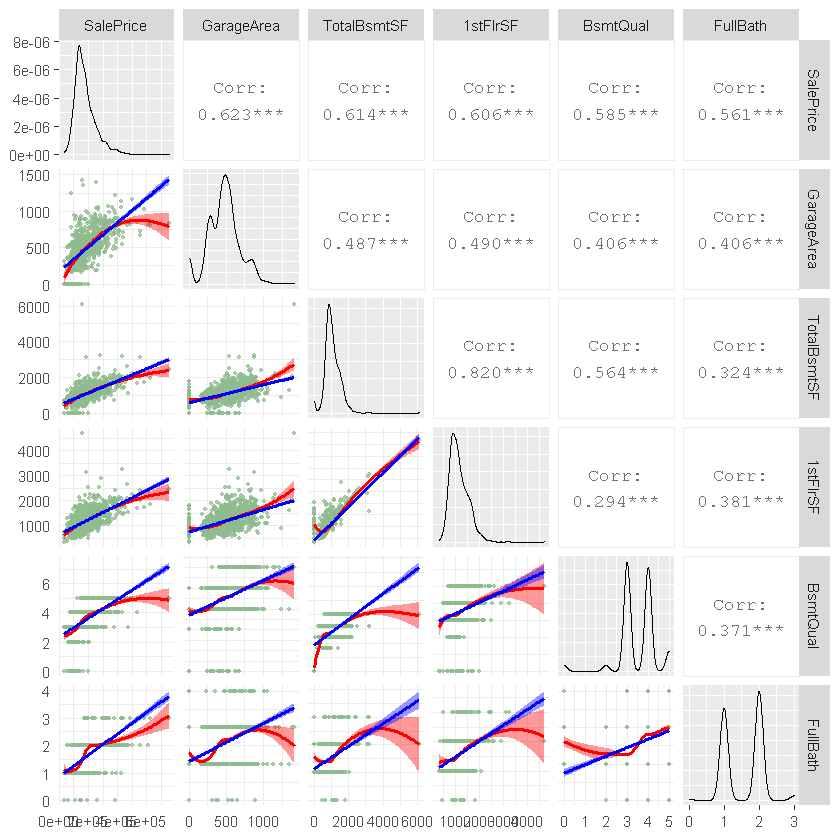

In [50]:
# Batch number two
ggpairs(houses, highCorrelation[c(1,7:11)], lower = list(continuous = lm.plt))

### Ok, we want to go about this very carefully, as removing outliers from our training data that, due to our use of cross-validation, will also serve as test data, could be consider "cheating" in a way when it comes to evaluating the effectiveness of our model. We argue however, that they make our model have less variance overall, since removing outliers allows for our model to better align with the trends of the housing market as a whole. Single our sample size is rather large, we expect that, the better a model fits most of our data here (i.e. our data excluding outliers), the better it will fit future test data.

### Now, with that disclaimer out of the wat, let us take a look at OverallQual. From the small graph above, it appears there is an outlier at OverallQual=4 where the sale price is abnormally high, as well as an outlier at OverallQual=8 where the sales price is abnomally high. At OverallQual=10, there is a wide range of sale values, but a couple of them appear abnormally high. Let us take a closer look at these values using quick plot:

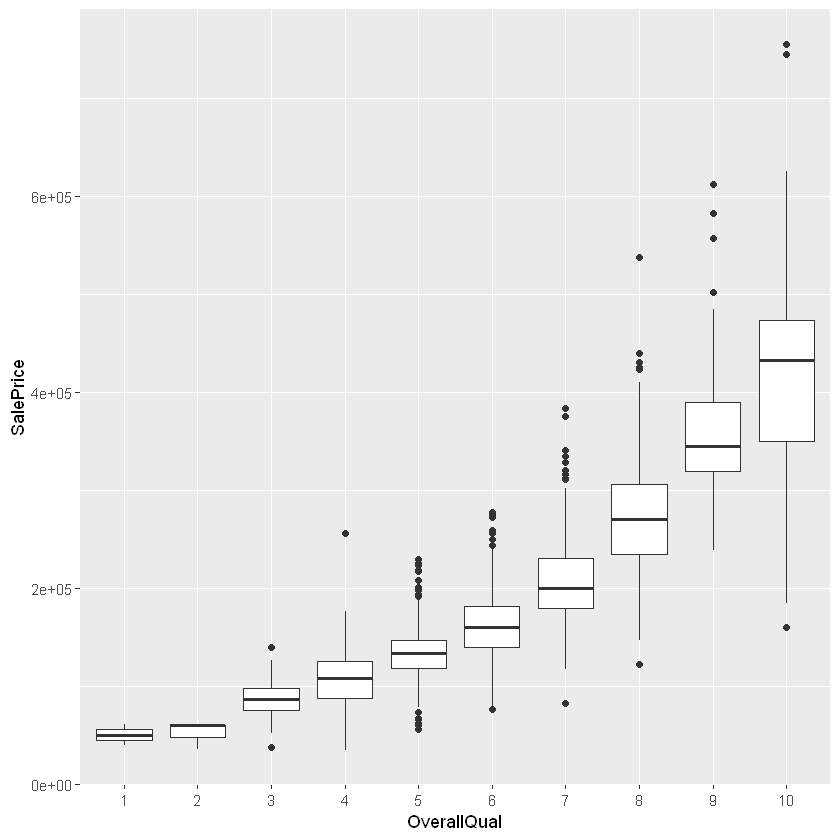

In [51]:
qplot(factor(OverallQual),SalePrice, data = houses, geom='boxplot',xlab='OverallQual')

### It's a tough decision...it seems the outlier at 4 and the outlier at 8 are exceptionally far from the mean given the data spread at these quality levels. Now, the variance in sales prices at this quality level 10 is pretty high, so eliminating those outliers is slightly harder to justify. Out of an excess of caution, we shall eliminate the outliers at 4 and 8 but leave the ones at 10.

### Now, to target these outliers, it appears that 4 has sale price greater than 200000 and the one at 8 has sale price greater than 500000, so we can find them via these two values:

In [52]:
outliersOverallQual1 <- which(houses$OverallQual == 4 & houses$SalePrice > 200000 )
houses <- houses[-outliersOverallQual1,]

outliersOverallQual2 <- which(houses$OverallQual == 8 & houses$SalePrice > 500000 )
houses <- houses[-outliersOverallQual2,]
dim(houses)

[1] 1458   81

### Alright, we went from 1460 instances to 1458, so the removal worked. Now, let us look at the next most highly correlated feature, GrLivArea (i.e. living area above grade). From the small plot above, it looks like there are two outliers with outlandishly high values for this feature. Let us take a closer look with qplot:

`geom_smooth()` using formula 'y ~ x'


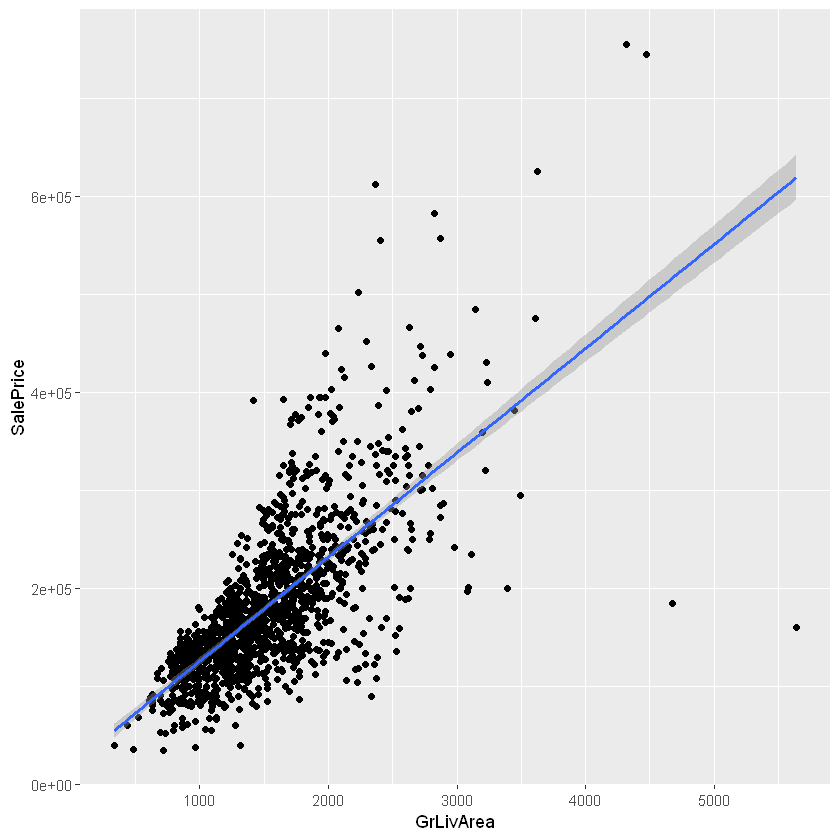

In [53]:
qplot(GrLivArea,SalePrice , data=houses, geom = c('point','smooth'), method='lm')

### Indeed, in the bottom right, we see two houses with large living area but relatively low sales prices. Perhaps these houses are on the outskirts of the city where space is not at a premium, or perhaps they were run-down and in a state of disrepair, but they are pulling the trendline down away from a more upward direction that would likely make them fit the data better. We can improve the predictive power of our model by eliminating them. While we are here, we also notice those two pesky houses with extraordinarily high sale prices also appear to be outliers for this feature as well. Recall, these two houses were borderline outliers for OverallQual as well. At this point, it might be reasonable to go ahead and eliminate them to increase the predictive power of our model for the vast majority of houses/ We do this by noticing these are the only four points with GrLivArea greater than 400:

In [54]:
outliersGrLivArea <- which(houses$GrLivArea > 4000)
houses <- houses[-outliersGrLivArea,]
dim(houses)

[1] 1454   81

### Great! We went from 1458 instances to 1454. Lastly, both GarageArea and GarageCars appear to wildly deviate from a linear model at higher feature values; let us take a closer look at the latter:

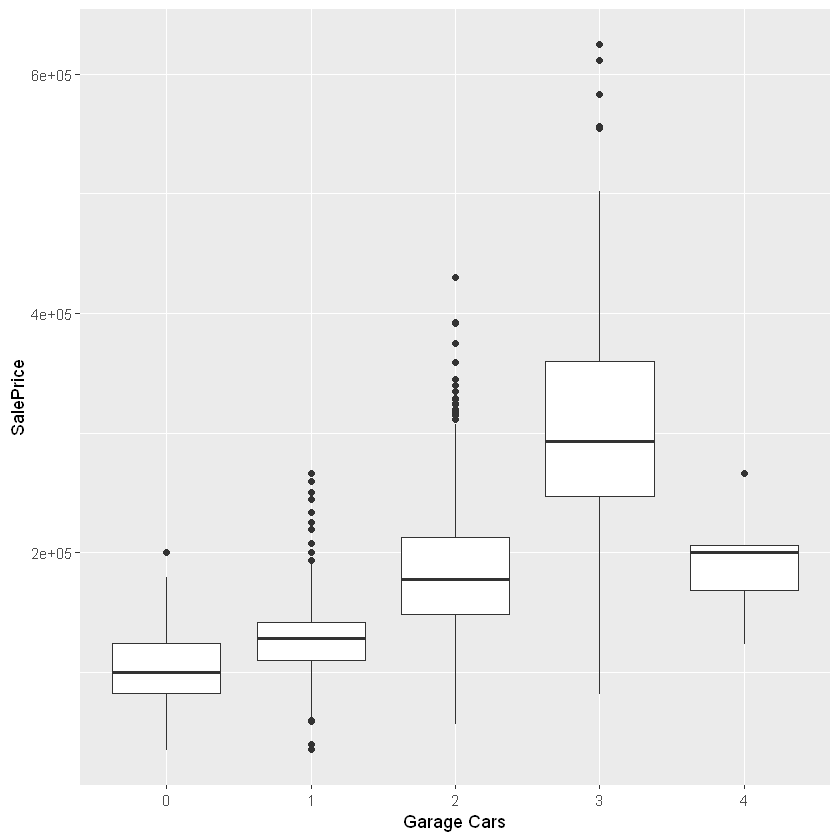

In [55]:
qplot(factor(GarageCars),SalePrice, data = houses, geom='boxplot', xlab='Garage Cars')

### We seem to have a linear relation up until GarageCars=4, when the value goes down again. There doesn't seem to be a good, logical way to fix this. We shouldn't try to introduce a new feature like GarageCars^2 or GarageCars^3 or anything like that to better match the data, because we might get some unfortunately results if in an eventual test set we had a house with GarageCars=5, in which case a quadratic model might predict a negative price and a cubic model likewise could predict a negative or very high price. That is to say, while doing something like that here wouldn't be an issue, overfitting here could create too much variance for future test sets we might want to use this model on (for instance, if I wanted to use this model on the Kaggle test set as a competition entry). For that reason, we will let this feature be.

### Now, we notice that the trend of GarageArea diverges from a linear model in a similar way to GarageCars. In fact, if we look at the corrmap above, these two variables are highly correlated for obvious reasons: the bigger the garage, the more cars it can store. Let us look at the exact value here:

In [56]:
correlation

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath,GarageFinish,TotRmsAbvGrd,YearBuilt,FireplaceQu,GarageYrBlt,YearRemodAdd
SalePrice,1.0000000,0.7909816,0.7086245,0.6826392,0.6595997,0.6404092,0.6234314,0.6135806,0.6058522,0.5852072,0.5606638,0.5492468,0.53372316,0.52289733,0.5204376,0.5080433,0.5071010
OverallQual,0.7909816,1.0000000,0.5930074,0.7262785,0.6733308,0.6006707,0.5620218,0.5378085,0.4762238,0.6293791,0.5505997,0.5568634,0.42745234,0.57232277,0.4907878,0.5550219,0.5506839
GrLivArea,0.7086245,0.5930074,1.0000000,0.4359861,0.4205627,0.4672474,0.4689975,0.4548682,0.5660240,0.3279556,0.6300116,0.3530215,0.82548937,0.19900971,0.4699468,0.2353869,0.2873885
ExterQual,0.6826392,0.7262785,0.4359861,1.0000000,0.7161222,0.5263902,0.4957776,0.4705796,0.3978354,0.5655581,0.4839494,0.5190542,0.29790278,0.59816048,0.3617980,0.5833311,0.5873184
KitchenQual,0.6595997,0.6733308,0.4205627,0.7161222,1.0000000,0.5098096,0.4896056,0.4326296,0.3870273,0.5109380,0.4346480,0.4745698,0.28727854,0.53016534,0.3538059,0.5352806,0.6253161
GarageCars,0.6404092,0.6006707,0.4672474,0.5263902,0.5098096,1.0000000,0.8824754,0.4345848,0.4393168,0.4491944,0.4696720,0.5797290,0.36228857,0.53785009,0.3700339,0.6198969,0.4206222
GarageArea,0.6234314,0.5620218,0.4689975,0.4957776,0.4896056,0.8824754,1.0000000,0.4866655,0.4897817,0.4061091,0.4056562,0.5164279,0.33782212,0.47895382,0.3279733,0.6028032,0.3715998
TotalBsmtSF,0.6135806,0.5378085,0.4548682,0.4705796,0.4326296,0.4345848,0.4866655,1.0000000,0.8195300,0.5642988,0.3237224,0.3715143,0.28557256,0.39145200,0.3476154,0.3459364,0.2910656
1stFlrSF,0.6058522,0.4762238,0.5660240,0.3978354,0.3870273,0.4393168,0.4897817,0.8195300,1.0000000,0.2935980,0.3806375,0.3341385,0.40951598,0.28198586,0.4078874,0.2657773,0.2403793
BsmtQual,0.5852072,0.6293791,0.3279556,0.5655581,0.5109380,0.4491944,0.4061091,0.5642988,0.2935980,1.0000000,0.3712430,0.4851840,0.18584583,0.60279701,0.3073370,0.5648719,0.5150133


### Indeed, GarageCars and GarageArea have a correlation of 0.8825. Now, with two features so highly correlated that both have an unfortunate non-linear trend for higher values, we fear that they are factoring in disproportionately in our linear model, since we are essentially getting penalized twice for big garages, drags the linear model dow, decreasing the coefficients for these features and making the model worse overall for houses with small garages. In order to reduce this effect, let us only keep one, GarageCars, since it has a higher correlation with SalePrice.

### While we're at it, there appear to be lots of highly correlated features that may be introducing unnecessary noise into our model since we are measuring the same physical thing twice. Also, GarageYrBlt predictably has a very high correlation with YearBlt at 0.84514. Why don't  we eliminate GarageYrBlt since it has a lower correlation with SalePrice. Lastly, for obvious reasons (more rooms=more area usually), TotalRmsAbvGrd has 0.8255 correlation with GrLivArea, so we will ditch the former since the latter has better correlation with SalePrice

In [57]:
houses <- houses[,!(names(houses) %in% c('GarageYrBlt', 'GarageArea', 'TotRmsAbvGrd'))]

In [58]:
dim(houses)

[1] 1454   78

### Ok, we are down to 78 features. This whole concept of eliminating highly correlated features gives us an idea. Perhaps, we can combine certain features into a single feature that will summarize these features, in such a way that we can keep the single feature and possibly eliminate the others. For instance, something that may summarize all the area variables in a useful way is a variable that simply sums all the area features to get total area of the house. Let us make this feature and see how it correlates with SalePrice:

In [59]:
houses$TotalSF <- houses$GrLivArea + houses$TotalBsmtSF
print(paste("Correlation: ", cor(houses$TotalSF, houses$SalePrice)))

[1] "Correlation:  0.819934502813852"


### Wow, we have just made our best feature yet! Another one that might be interesting is the age of the house when it was sold (taking remodeling into account). Obviously, under the hood, our linear model assigns coefficients to the two features to take this into account, but if we explicitly make then feature, we might be able to eliminate YrSold and YrRemodAdd to streamline our model a litte:

In [60]:
houses$AgeWhenSold <- as.numeric(houses$YrSold)-houses$YearRemodAdd
print(paste("Correlation: ", cor(houses$AgeWhenSold, houses$SalePrice)))

[1] "Correlation:  -0.524579871380559"


### Ok, not bad. This is a slightly better predictor of SalePrice than YrBlt or YearRemodAdd, so this is a slight improvement. Now, another one we might try is a simplification of the two bathroom features (FullBath and HalfBath) into a single feature. TotBathrooms:

In [61]:
houses$TotBathrooms <- houses$FullBath + (houses$HalfBath*0.5) + houses$BsmtFullBath + (houses$BsmtHalfBath*0.5)
print(paste("Correlation: ", cor(houses$TotBathrooms, houses$SalePrice)))

[1] "Correlation:  0.633526616680689"


### Ah, another useful feature indeed. Now, we might try to add some categorical binary features to improve learning, as these types of features won't introduce any noise into the model since they are just 0 or 1, and might fix some of the noise issues with measurement or quality features related to the items in question. For instance, a hasGarage feature and a hasPool feature might smooth out some of the noise from using measurements related to these two features alone (since all the zero values for the measurement features will drag down that regression line, when it would be better to move up the intercept for cases when we know a house has a pool to better model the increases in SalePrice related to changes in this value)

In [62]:
houses$HasGarage <- ifelse(houses$GarageCars > 0, 1, 0)
print(paste("Correlation: ", cor(houses$HasGarage, houses$SalePrice)))
houses$HasPool <- ifelse(houses$PoolArea > 0, 1, 0)
print(paste("Correlation: ", cor(houses$HasPool, houses$SalePrice)))

[1] "Correlation:  0.244214134778817"
[1] "Correlation:  0.0328290738660012"


### The correlation isn't high, but that isn't the function of these features. They will help with the linear model later on. Another useful categorical feature might be whether or not the house was new when it was sold (i.e. YrSold=YearBuilt). With cars, houses, boats, and other high-value items, there is a certain premium that one must pay to buy the item new vs. used. To take this into account, we can introduce a feature that will indicate this:

In [63]:
houses$WasNew <- ifelse(houses$YrSold==houses$YearBuilt, 1, 0)
print(paste("Correlation: ", cor(houses$WasNew, houses$SalePrice)))

[1] "Correlation:  0.242359604571845"


### Once again, this feature is less about correlation and more about improving the linear model. I mostly am just calculating the correlation for these categorical features to make sure they got added successfully to the data frame. Now, last of these binary features we will add is whether or not the home has been remodeled. If so, it might correspond to a certain flat increase in home value that we might want to take into account:

In [64]:
houses$Remodeled <- ifelse(houses$YearBuilt==houses$YearRemodAdd, 0, 1)
print(paste("Correlation: ", cor(houses$Remodeled, houses$SalePrice)))

[1] "Correlation:  -0.0213972753460313"


### Lastly, it is possible that certain neighbourhoods are gated communities or otherwise rich neighbourhoods, and experience a sharp increase in price by the fact itself of being location in these neighbourhoods. Similarly, perhaps certain areas might be categorically more poor and blighted than others, experiencing a sharp drop-off in home prices. The kinds of divisions might negatively impact our linear model since the sharp spike in prices in rich neighbourhoods cannot be accurately modeled by the same line that also must fit the prices in the rest of the neighbourhoods. Similarly, a straight linear model on home prices might have issues with a sharp drop-off in prices for particularly blighted neightbourhoods. The solution is to introduce a feature that will step up everytime there is a sharp increase in price levels between neighbourhoods. Let us take a look at the median sales prices in different neighbourhoods to see if there is a noticeable spike anywhere:

No summary function supplied, defaulting to `mean_se()`


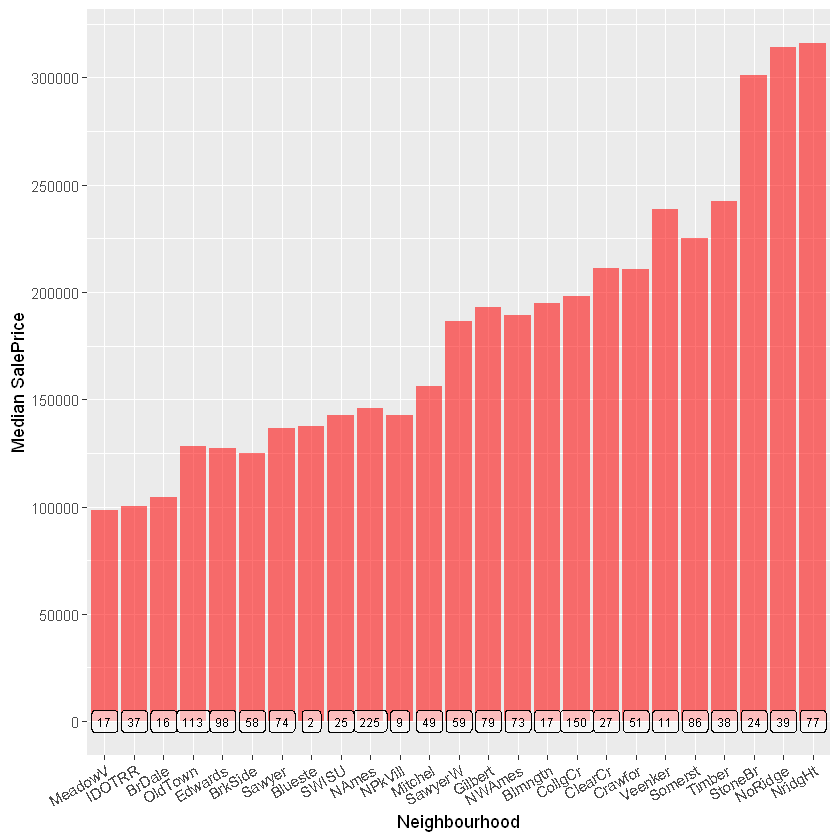

In [65]:
ggplot(houses, aes(x=reorder(Neighborhood, SalePrice, FUN=median), y=SalePrice, alpha=I(0.55))) +
        geom_bar(stat='summary', fun.y = "median", fill='red') + labs(x='Neighbourhood', y='Median SalePrice') +
        theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
        scale_y_continuous(breaks= seq(0, 400000, by=50000)) +
        geom_label(stat = "count", aes(label = ..count.., y = ..count..), size=2.5)

### Indeed, it looks like we have 3 groups that internally each follow a vaguely linear trend. After the initial 3 poorest neighbourhoods (MeadowV, IDOTRR, and BrDale), there is a small jump, then we have a large group of neighbourhoods in the middle where median price value goes up more or less linearly, then there is another jump to a group of rich neighbourhoods StoneBy, NoRidge, and NridgHt, where home prices are markedly higher. Let us create labels for these different groups of homes, 0 for the poorest neighbourhoods, 1 for the main group, and 2 for the richest neighbourhoods:

In [66]:
houses$NeighClass[houses$Neighborhood %in% c('StoneBr', 'NridgHt', 'NoRidge')] <- 2
houses$NeighClass[!houses$Neighborhood %in% c('MeadowV', 'IDOTRR', 'BrDale', 'StoneBr', 'NridgHt', 'NoRidge')] <- 1
houses$NeighClass[houses$Neighborhood %in% c('MeadowV', 'IDOTRR', 'BrDale')] <- 0

print(paste("Correlation: ", cor(houses$NeighClass, houses$SalePrice)))

[1] "Correlation:  0.5795898901631"


### This is already an effective feature on the basis of its correlation alone, and it should work well in combination with others in the linear model. Now, the goal of a lot of these features was to be able to remove similar features with which they correlate strongly, so let us take a look at the correlation matrix again and see if these high expected correlations pan out:

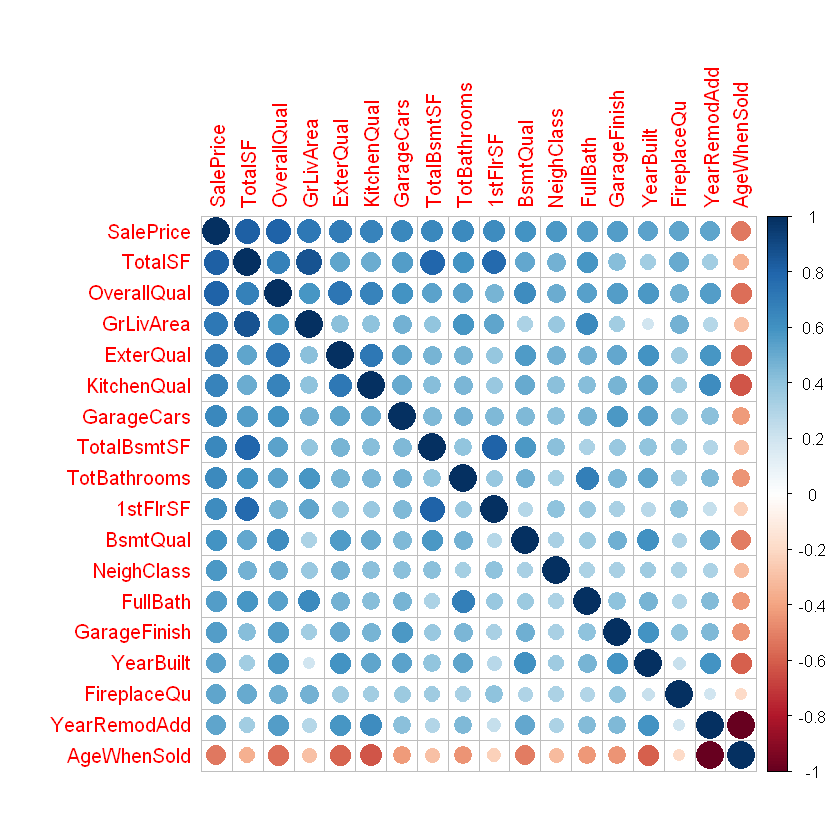

In [67]:
# First this only works for numeric variables, so let us make a df with those
numericVariables <-  unlist(lapply(houses, is.numeric))
# Now we find the correlation between the different numeric features
correlation = cor(houses[numericVariables])
# Now we will order them in order of which features have the highest correlation with SalePrice
correlation_sorted <- as.matrix(sort(correlation[,'SalePrice'], decreasing = TRUE))
# So our graphic isn't too big, let us only look at ones that have a correlation with magnitude greater than 0.5 (in either direction)
highCorrelation <- names(which(apply(correlation_sorted, 1, function(x) abs(x)>0.5)))
correlation <- correlation[highCorrelation, highCorrelation]
corrplot(correlation)

### As planned, our best new best feature, TotalSF, correlated highly with TotalBsmtSF and 1stFlrSF. How highly? Let us take a look at the matrix:

In [68]:
correlation

,SalePrice,TotalSF,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,TotalBsmtSF,TotBathrooms,1stFlrSF,BsmtQual,NeighClass,FullBath,GarageFinish,YearBuilt,FireplaceQu,YearRemodAdd,AgeWhenSold
SalePrice,1.0000000,0.8199345,0.8049165,0.7176366,0.6934904,0.6649624,0.6494586,0.6470769,0.6335266,0.6254278,0.5945915,0.5795899,0.5572099,0.5563504,0.5367659,0.5288297,0.5225779,-0.5245799
TotalSF,0.8199345,1.0000000,0.6708351,0.8662759,0.5244044,0.4953830,0.5515700,0.7999446,0.5972161,0.7756388,0.5196826,0.4717582,0.5866698,0.4286573,0.3418912,0.5013625,0.3480132,-0.3500955
OverallQual,0.8049165,0.6708351,1.0000000,0.5838634,0.7216979,0.6687683,0.5989466,0.5333455,0.5303760,0.4634053,0.6265435,0.4904493,0.5424763,0.5550940,0.5712256,0.4892141,0.5515871,-0.5533702
GrLivArea,0.7176366,0.8662759,0.5838634,1.0000000,0.4182864,0.4046005,0.4724748,0.3931962,0.5835242,0.5220974,0.3173981,0.3738002,0.6334676,0.3470682,0.1911231,0.4765680,0.2883782,-0.2907682
ExterQual,0.6934904,0.5244044,0.7216979,0.4182864,1.0000000,0.7119309,0.5231397,0.4627283,0.4633461,0.3819678,0.5623102,0.4734863,0.4751176,0.5156611,0.5971232,0.3567741,0.5876636,-0.5882694
KitchenQual,0.6649624,0.4953830,0.6687683,0.4046005,0.7119309,1.0000000,0.5053878,0.4257535,0.4537620,0.3730054,0.5057644,0.4112987,0.4258603,0.4688930,0.5283991,0.3481220,0.6250917,-0.6250957
GarageCars,0.6494586,0.5515700,0.5989466,0.4724748,0.5231397,0.5053878,1.0000000,0.4476363,0.4788101,0.4449605,0.4457924,0.4172661,0.4642803,0.5772445,0.5364615,0.3666300,0.4190231,-0.4216353
TotalBsmtSF,0.6470769,0.7999446,0.5333455,0.3931962,0.4627283,0.4257535,0.4476363,1.0000000,0.3982567,0.8004301,0.5752238,0.4192690,0.3188547,0.3720517,0.3996778,0.3503122,0.2941236,-0.2950852
TotBathrooms,0.6335266,0.5972161,0.5303760,0.5835242,0.4633461,0.4537620,0.4788101,0.3982567,1.0000000,0.3701456,0.4738614,0.3391675,0.6888050,0.4558407,0.5225437,0.3213974,0.4423063,-0.4410965
1stFlrSF,0.6254278,0.7756388,0.4634053,0.5220974,0.3819678,0.3730054,0.4449605,0.8004301,0.3701456,1.0000000,0.2824169,0.4095564,0.3745238,0.3277767,0.2799385,0.4090786,0.2374142,-0.2382260


### With correlations of 0.7999 and 0.776 respectively, it seems reasonable to remove these two and only keep TotalSF, which we will do presently:

In [69]:
print(dim(houses))
houses <- houses[,!(names(houses) %in% c('TotalBsmtSF', '1stFlrSF'))]
print(dim(houses))

[1] 1454   86
[1] 1454   84


### Great. Now, if this initial revamped linear model doesn't work out, we may try some fancier types of regressions, ensemble methods, etc. In order to do this, depending on the package, certain issues can arise when column names begin with numbers, so to avoid potential issues, we shall relabel them to begin with characters.

In [70]:
houses$SecondFlrSF <- houses$`2ndFlrSF`
houses$ThreeSeasonPorch <- houses$`3SsnPorch`
houses$`2ndFlrSF` <- NULL
houses$`3SsnPorch` <- NULL
dim(houses)

[1] 1454   84

### Great, now the last thing we might do to improve learning is to normalize numeric variables. Normalizing the feature data will solve the problem of certain features weighing disproportionately in the regression algorithm due to their scale. For instance, GrLivArea is typically in the hundreds or thousands, but variables about number of types of rooms, LotFrontage, GarageCars, etc. are much smaller. For least squares regression, this disproportiately forces the algorithm to focus on minimizing error for GrLivArea at the expense of other features. First we standardize which recenters the data at zero and divides by variance for that feature so it has roughly unit variance. To make this stage nice and easy, we do use the package caret

In [71]:
library(caret)

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [73]:
numVars <- which(sapply(houses, is.numeric))
numVarNames <- names(numVars)
numVarNames <- numVarNames[!(numVarNames %in% c('MSSubClass', 'MoSold', 'YrSold', 'SalePrice', 'OverallQual', 'OverallCond'))]
numVars <- houses[, names(houses) %in% numVarNames]
factors <- houses[, !(names(houses) %in% numVarNames)]
salePrices <- houses$SalePrice

In [74]:
preprocessNum <- preProcess(numVars, method=c("center", "scale"))
print(preprocessNum)
normNum <- predict(preprocessNum, numVars)
dim(normNum)

Created from 1454 samples and 56 variables

Pre-processing:
  - centered (56)
  - ignored (0)
  - scaled (56)



[1] 1454   56

In [75]:
head(normNum)

Id,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,...,TotalSF,AgeWhenSold,TotBathrooms,HasGarage,HasPool,WasNew,Remodeled,NeighClass,SecondFlrSF,ThreeSeasonPorch
-1.727987,-0.22984606,-0.19919289,0.06434902,0.6994793,0.02622514,0.2229193,1.0535346,0.8809268,0.5364404,...,0.01423228,-0.8721981,1.6703926,0.2428051,-0.05872208,-0.210973,-0.9539484,-0.1276644,1.1872137,-0.1165422
-1.725617,0.47303427,-0.08109952,0.06434902,0.6994793,0.02622514,0.2229193,0.1597162,-0.4259821,-0.5732612,...,-0.04114792,0.3865855,0.3822723,0.2428051,-0.05872208,-0.210973,-0.9539484,-0.1276644,-0.7965578,-0.1165422
-1.723247,-0.08926999,0.08833880,0.06434902,-1.0331321,0.02622514,0.2229193,0.9873259,0.8325228,0.3439412,...,0.19883295,-0.8237833,1.6703926,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,1.2150887,-0.1165422
-1.720877,-0.46413950,-0.08623401,0.06434902,-1.0331321,0.02622514,0.2229193,-1.8596515,-0.7164064,-0.5732612,...,-0.10839531,0.6286592,-0.2617879,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,0.9595678,-0.1165422
-1.718507,0.66046903,0.39743537,0.06434902,-1.0331321,0.02622514,0.2229193,0.9542215,0.7357147,1.4083489,...,1.03876599,-0.7269538,1.6703926,0.2428051,-0.05872208,-0.210973,-0.9539484,2.5241073,1.6494742,-0.1165422
-1.716137,0.70732771,0.38254534,0.06434902,-1.0331321,0.02622514,0.2229193,0.7224907,0.4936945,-0.5732612,...,-0.52374681,-0.4364653,0.3822723,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,0.5182135,10.7763409


### It is not that we finally realize that we have kept the useless Id feature this whole time, so we will eliminate it now:

In [76]:
normNum <- normNum[,!(names(normNum) %in% c('Id'))]

In [77]:
head(normNum)

LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,TotalSF,AgeWhenSold,TotBathrooms,HasGarage,HasPool,WasNew,Remodeled,NeighClass,SecondFlrSF,ThreeSeasonPorch
-0.22984606,-0.19919289,0.06434902,0.6994793,0.02622514,0.2229193,1.0535346,0.8809268,0.5364404,1.0698181,...,0.01423228,-0.8721981,1.6703926,0.2428051,-0.05872208,-0.210973,-0.9539484,-0.1276644,1.1872137,-0.1165422
0.47303427,-0.08109952,0.06434902,0.6994793,0.02622514,0.2229193,0.1597162,-0.4259821,-0.5732612,-0.6878266,...,-0.04114792,0.3865855,0.3822723,0.2428051,-0.05872208,-0.210973,-0.9539484,-0.1276644,-0.7965578,-0.1165422
-0.08926999,0.08833880,0.06434902,-1.0331321,0.02622514,0.2229193,0.9873259,0.8325228,0.3439412,1.0698181,...,0.19883295,-0.8237833,1.6703926,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,1.2150887,-0.1165422
-0.46413950,-0.08623401,0.06434902,-1.0331321,0.02622514,0.2229193,-1.8596515,-0.7164064,-0.5732612,-0.6878266,...,-0.10839531,0.6286592,-0.2617879,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,0.9595678,-0.1165422
0.66046903,0.39743537,0.06434902,-1.0331321,0.02622514,0.2229193,0.9542215,0.7357147,1.4083489,1.0698181,...,1.03876599,-0.7269538,1.6703926,0.2428051,-0.05872208,-0.210973,-0.9539484,2.5241073,1.6494742,-0.1165422
0.70732771,0.38254534,0.06434902,-1.0331321,0.02622514,0.2229193,0.7224907,0.4936945,-0.5732612,-0.6878266,...,-0.52374681,-0.4364653,0.3822723,0.2428051,-0.05872208,-0.210973,1.0475537,-0.1276644,0.5182135,10.7763409


### Let us put these normalized features back together with the factor variables:

In [78]:
houses <- cbind(normNum, factors)

### Now, lastly, let us go ahead and try to fix the skew in the SalePrices by taking the log, as discussed earlier

In [79]:
houses$SalePrice <- log(salePrices)

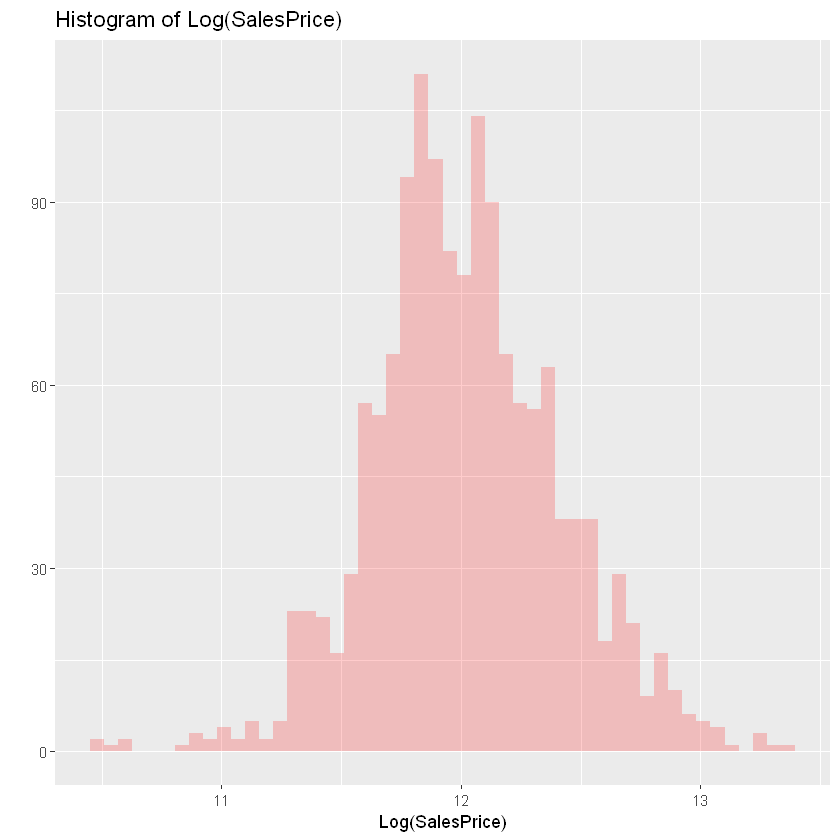

In [80]:
qplot(houses$SalePrice, geom='histogram', bins=50, alpha=I(0.2), fill=I('red'), main='Histogram of Log(SalesPrice)', xlab='Log(SalesPrice)')

### Looks good. We are ready to try our linear model again

# End of Pre-Processing

# Linear Model, Take 2

In [81]:
houses_h2o <- as.h2o(houses)
response <- "SalePrice"
predictors <- setdiff(names(houses_h2o), response)
houses_glm <- h2o.glm(family = "gaussian",
                        x = predictors,
                        y = response,
                        training_frame = houses_h2o,
                        nfolds = 5)

  |======================================================================| 100%
  |======================================================================| 100%


In [82]:
houses_glm

Model Details:

H2ORegressionModel: glm
Model ID:  GLM_model_R_1596161807875_2 
GLM Model: summary
    family     link                               regularization
1 gaussian identity Elastic Net (alpha = 0.5, lambda = 0.06486 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        258                          19                    2
     training_frame
1 houses_sid_a4fd_3

Coefficients: glm coefficients
                 names coefficients standardized_coefficients
1            Intercept    11.578699                 12.020840
2 Neighborhood.Blmngtn     0.000000                  0.000000
3 Neighborhood.Blueste     0.000000                  0.000000
4  Neighborhood.BrDale     0.000000                  0.000000
5 Neighborhood.BrkSide     0.000000                  0.000000

---
               names coefficients standardized_coefficients
254        Remodeled     0.000000                  0.000000
255       NeighClass     0.018385             

### Great! A RMSLE of 0.01177 would be 66 on the Kaggle leaderboard. Granted, we have cheated a little bit by removing outliers that should in theory be in our test sets during cross-validation, which means our error is "artificially" low in a manner of speaking, but this is still a good result.

### Since we have a good number of features, another model we might be interested in is a linear model with lasso regression, which basically adds a regularization term times the sum of the absolute value of feature weights to the loss function, which has the effect of, well, regularizing the regression process (i.e. making it less sensitive to the training data, decreasing variance), but also will have the effect of decreasing the weights of features that do not play a significant role in the final linear model. In theory, since certain features may only be weakly correlated with SalePrice, this is a good property to have. 

### Now, the way this is implemented in R is with glmnet method in train method in caret. glmnet combines both lasso and ridge regression in a single method, with 0 <= alpha <= 1 as a parameter to select how much of each type we want. Here we set alpha=1 to get only lasso regression. Now, we need to find the best regularization parameter, lambda, that minimizes RMSE (unfortunately glmnet does not output RMSE, so we can only compare if this method is better or worse than our linear model above). Now, how do we chose lambda? Lambda can take on any value, so it is not clear how to proceed. Since we only want to improve on our result from earlier, and since the numerical features are normalized, we needn't focus on large values for lambda, so we will sweep form 0.001 to 0.1 with a step size of 0.0005. Stopping at 0.1 will prevent too much regularization, which might induce bias into our model. We  will perform 5-fold cross validation to test our model. We use the tuneGrid parameter to find the best lambda (in terms of RMSE) and will find the value of the RMSE at this lambda. 

In [83]:
traincv <- trainControl(method="cv", number=5)
lassoGrid <- expand.grid(alpha = 1, lambda = seq(0.001,0.1,by = 0.0005))

lasso_model <- train(SalePrice~.,data=houses, method='glmnet', trControl= traincv, tuneGrid=lassoGrid) 
lasso_model$bestTune

,alpha,lambda
8,1,0.0045


### So a regularization parameter of 0.0045 results in the best RMSE, which is...

In [86]:
min(lasso_model$results$RMSE)

[1] 0.1156105

### Not bad. Recall that our earlier linear model had RMSE:  0.1509139, so it appears this model is slightly better. Unfortunately, since no RMSLE is provided, we cannot compare our result to the Kaggle leaderboard. Lastly, as mentioned earlier, Lasso regression has the property of removing features that are not useful in the regression model. Out of curiosity, let us see how many features were removed (i.e. whose weight is equal to zero)

In [88]:
lassoFeatImp <- varImp(lasso_model,scale=F)
lassoImportance <- lassoFeatImp$importance

featSelected <- length(which(lassoImportance$Overall!=0))
featNotSelected <- length(which(lassoImportance$Overall==0))

cat('Lasso used', featSelected, 'features, did not use', featNotSelected, 'features')

Lasso used 61 features, did not use 173 features

### This is perhaps Lasso regression's strength, i.e. eliminating features that are not useful in the model and are just generating noise. "Why are these so many features?", we might be asking ourselves. Recall that for factor variables, a lot of R methods will one-hot encode the different values for the variable so that, from the viewpoint of the train method earlier, we have many, many more features than the 80 some-odd features in the dataframe.